In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "hypo_DMRs.09.26.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_4074699/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,Microglia,5.104929e-07,1.249657e-07,0.000022,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,4.656938
1,Lymphocyte,3.603964e-07,1.303881e-07,0.002855,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,2.544449
2,Endo,7.704963e-08,8.279106e-08,0.176017,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,0.754446
3,VLMC,6.201615e-08,1.101557e-07,0.286722,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,0.542539
4,Pericyte,3.269990e-08,9.311298e-08,0.362725,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,0.440423


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

1209    0.017791
775     0.017791
0       0.022177
403     0.022177
868     0.025483
          ...   
1495    1.000000
1496    1.000000
1497    1.000000
1482    1.000000
3781    1.000000
Name: FDR_BH_corrected, Length: 3782, dtype: float64


In [9]:
print(adj_pval.sort_values())

1209    0.017791
775     0.019040
403     0.022177
868     0.025483
0       0.027776
          ...   
2371    1.152516
825     1.152533
2588    1.152571
1569    1.152766
3211    1.152809
Name: adj_pval, Length: 3782, dtype: float64


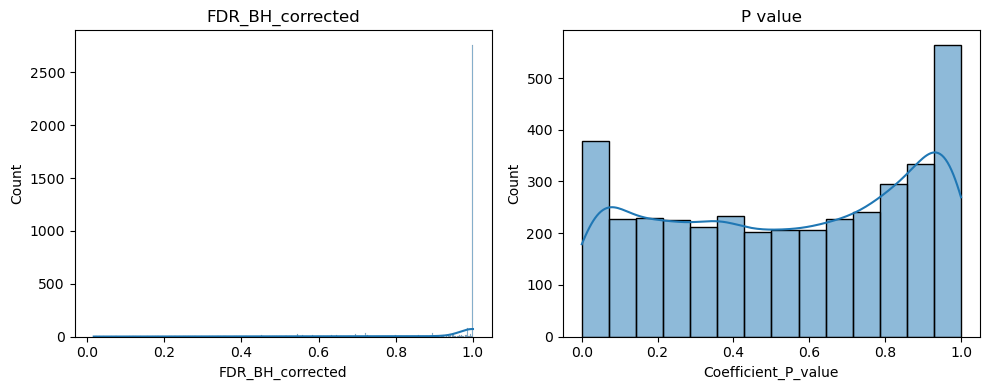

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.304447,0.050355,0.032930,0.139595,0.098451,0.180396,0.559601,0.718948,0.994519,0.379281,...,0.377185,0.545362,0.032511,0.016005,0.006376,0.031361,0.100005,0.017531,0.160320,0.031617
Astrocyte,0.003202,0.031692,0.244996,0.147074,0.000696,0.080564,0.496289,0.528262,0.182414,0.008846,...,1.201610,0.763321,0.099260,0.187669,0.137849,0.004957,0.498853,0.181429,0.801791,0.286942
CN_Cholinergic_GABA,0.072615,0.018534,0.102680,0.458344,0.000322,0.039569,1.028960,1.530809,1.574112,0.211047,...,1.093195,0.034211,0.290766,0.020450,0.019907,0.020080,0.288769,0.061958,0.443735,0.032117
CN_GABA-Glut,0.003040,1.264379,0.268151,1.116786,0.203465,0.358821,0.427661,2.134042,0.799657,0.459669,...,1.150844,0.094327,0.316431,0.123895,0.007888,0.071411,0.074587,0.038413,0.460023,0.111519
CN_LAMP5-CXCL14_GABA,0.007785,0.047209,0.135343,0.168563,0.080393,0.048166,0.105418,0.239078,0.855739,0.642610,...,1.043335,0.490855,0.099823,0.245744,0.159760,0.072330,0.595390,0.224815,2.828317,0.676028


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,0.947166,0.790074,1.000000,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000
Astrocyte,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,0.690413,0.924822,1.0,1.0,1.0,1.0,1.000000,1.0,0.904454,1.000000
CN_Cholinergic_GABA,1.0,1.000000,1.0,1.000000,1.0,1.0,0.765257,0.548804,0.544218,1.000000,...,0.724653,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000
CN_GABA-Glut,1.0,0.657259,1.0,0.722193,1.0,1.0,1.000000,0.324992,0.906164,1.000000,...,0.705079,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000
CN_LAMP5-CXCL14_GABA,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,0.881529,0.981742,...,0.753929,1.000000,1.0,1.0,1.0,1.0,0.984877,1.0,0.170440,0.965713


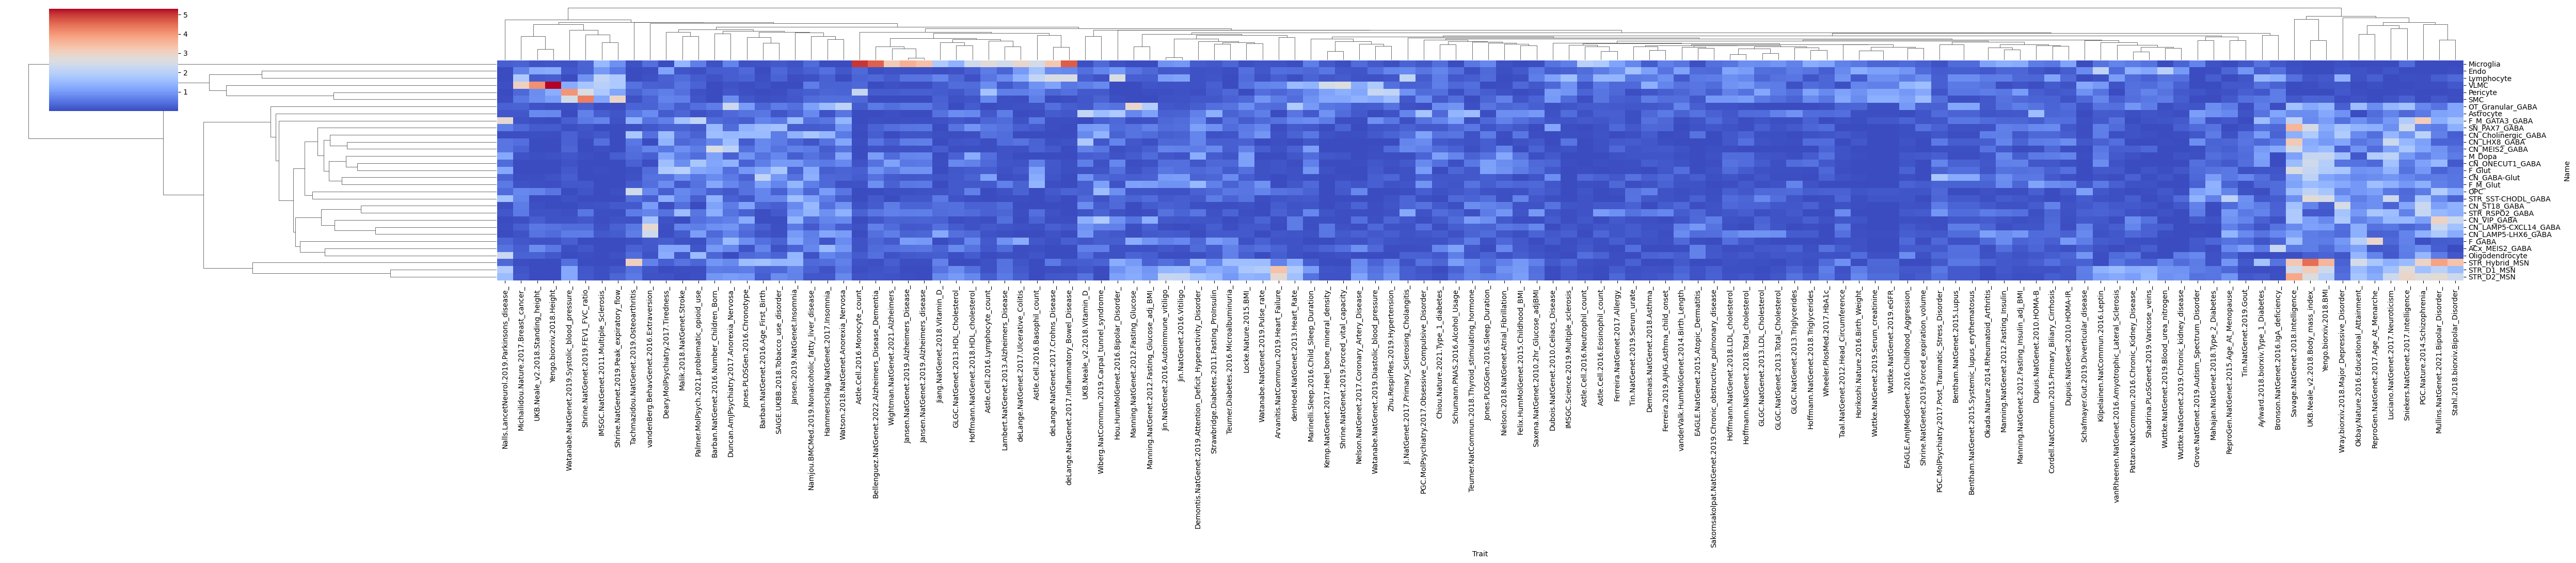

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

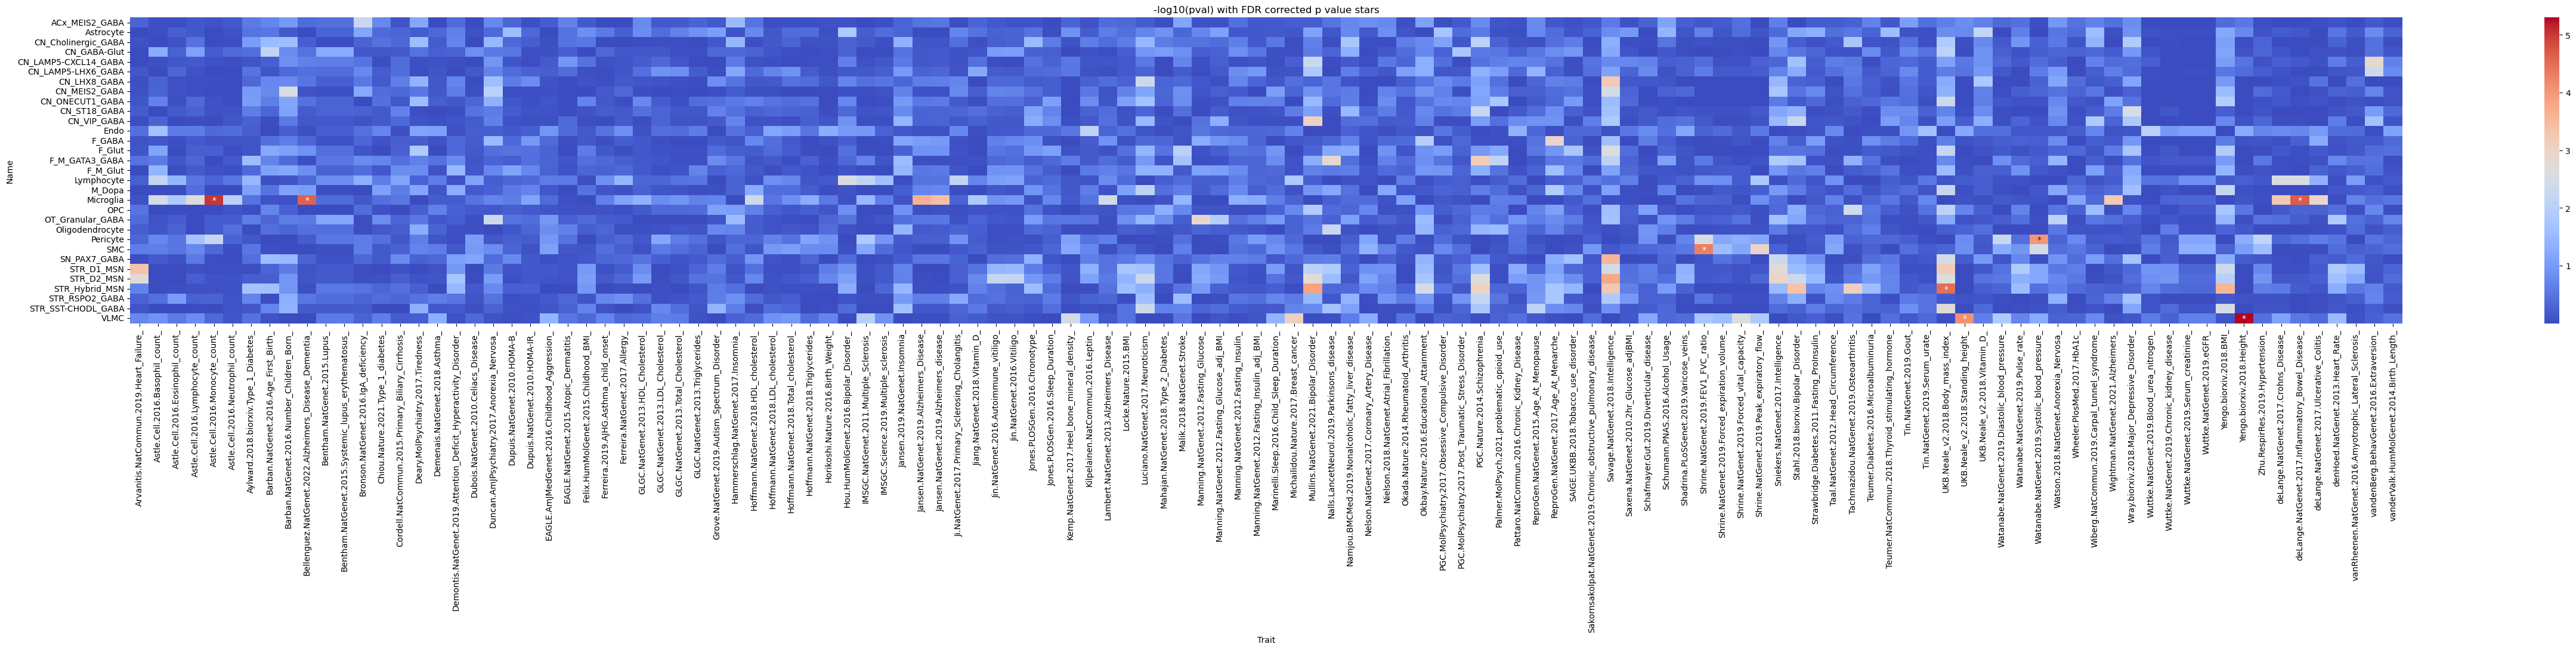

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

